# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display.  Once you have a working pipeline, try it out on the video stream below.**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.** 

---

## Import Packages

In [1]:
#importing some useful packages required for this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Helper Functions

In [2]:
def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    #Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


"""
TODO:
1) Created helper functions read_image and channel_threshold and draw_hough_lines
2) Modified draw_lines
"""
def read_image(img):
    # Reading images from the test directory
    testImageDir = 'test_images'
    return plt.imread(testImageDir + '/' + img)


def channel_threshold(rgb_thresholds, img):
    #Applying color thresholds to select the bright color
    color_select = np.copy(img)
    thresholds = (img[:,:,0]<rgb_thresholds[0])\
                    |(img[:,:,1]<rgb_thresholds[1])\
                    |(img[:,:,2]<rgb_thresholds[2])
    color_select[thresholds] = [0,0,0]
    return color_select


def draw_hough_lines(img, lines, array_x1, array_x2, array_y1, array_y2, color, thickness):
    # Calculate the average and the coordinates and draw the left line
    if 0 in {len(array_x1), len(array_x2)}:
        return
    
    print(array_x1)
    print(array_x2)
    print(array_y1)
    print(array_y2)
    # Calculating the average of all the coordinates
    average_x1 = np.ma.average(array_x1, weights=None)
    average_x2 = np.ma.average(array_x2, weights=None)
    average_y1 = np.ma.average(array_y1, weights=None)
    average_y2 = np.ma.average(array_y2, weights=None)
    
    # Calculating slope using the formula: slope = (y2-y1)/(x2-x1)
    slope = (average_y2 - average_y1)/(average_x2 - average_x1)
    
    # Calculating intercept using the formula of the line(y=mx +b): y = slope * x + intercept
    intercept = average_y2 - (slope * average_x2)
 
    # Calculating the coordinates x1, x2, y1 and y2 using averaged values
    y1 = img.shape[0] - int(img.shape[0]/3)
    y2 = img.shape[0]
    x1 = int((y1 - intercept)/slope) 
    x2 = int((y2 - intercept)/slope) 
    
    # Draw the line using the coordinates
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):  
    # Array of all the coordinates for the left and right lines
    left_x1 = []
    left_y1 = []
    left_x2 = []
    left_y2 = []
    
    right_x1 = []
    right_y1 = []
    right_x2 = []
    right_y2 = []
    
    # Troubleshooting for no lines in the image
    if lines is None:
        return
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_x1.append(x1)
                left_x2.append(x2)
                left_y1.append(y1)
                left_y2.append(y2)
            else:
                right_x1.append(x1)
                right_x2.append(x2)
                right_y1.append(y1)
                right_y2.append(y2)
    
    # Draw left line
    draw_hough_lines(img, lines, left_x1, left_x2, left_y1, left_y2, color, thickness)
    
    # Draw right line
    draw_hough_lines(img, lines, right_x1, right_x2, right_y1, right_y2, color, thickness)
  
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
    

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [3]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
write_path = 'test_images_output'

"""
The pipeline consists of a series of steps required to process an image to detect lanes. 
The following are the parameters which shall be used as arguments for the helper functions.
"""
#Initializing all the variables:
# 1. Color selection
red_threshold = 230
green_threshold = 0
blue_threshold = 0
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# 2. Gaussian Blur
kernel_size = 5

# 3. Canny Edge Detection
low_threshold = 50
high_threshold = 150

# 4. Hough Transform
rho = 2
theta = np.pi/180
threshold = 10
min_line_length = 20
max_line_gap = 1

"""BEGIN: The main pipeline function"""
def finding_lanes_pipeline(image):
    #Step 1.1: Color selection using channels
    color_select = channel_threshold(rgb_threshold, image)

    #Step 1.2: Convert it into grayscale
    gray = grayscale(color_select)
    
    #Step 2.1: Apply Gaussian Blur
    blurred_gray = gaussian_blur(gray, kernel_size)

    #Step 2.2: Apply Canny Edge detection
    edges = canny(blurred_gray,low_threshold,high_threshold)

    #Step 3: Mask the detected lines to the region of interest(ROI)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (450, 310), (490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    #Step 4: Apply Hough Transform using the following parameters
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    #Step 5: Interpolate the final result on the initial image
    final_image = weighted_img(line_image, image)
    return final_image
 
"""END: The main pipeline function"""  

"""BEGIN: Modified pipeline function for displaying figures of each step"""
def display_lanes_pipeline(image_file):
    
    #Step 0: Get the image from the image file name
    image = read_image(image_file)

    plt.figure(figsize=(14,9))
    plt.title("Initial Image: "+ image_file)
    plt.imshow(image)
    plt.show()

    #Preparing for subplots of different Processes
    plt.figure(figsize=(14,12))


    #Step 1.1: Color selection using channels
    color_select = channel_threshold(rgb_threshold, image)

    plt.subplot(321)
    plt.title("Color Selected Image: "+ image_file)
    plt.imshow(color_select)


    #Step 1.2: Convert it into grayscale
    gray = grayscale(color_select)
 
    plt.subplot(322)
    plt.title("Grayscale Image: "+ image_file)
    plt.imshow(gray, cmap='gray')


    #Step 2.1: Apply Gaussian Blur
    blurred_gray = gaussian_blur(gray, kernel_size)

    plt.subplot(323)
    plt.title("Gaussian Smoothing applied: "+ image_file)
    plt.imshow(blurred_gray, cmap='gray')


    #Step 2.2: Apply Canny Edge detection
    edges = canny(blurred_gray,low_threshold,high_threshold)

    plt.subplot(324)
    plt.title("Canny Edge detected image: "+ image_file)
    plt.imshow(edges, cmap='gray')


    #Step 3: Mask the detected lines to the region of interest(ROI)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (450, 310), (490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    plt.subplot(325)
    plt.title("Masked Image: "+ image_file)
    plt.imshow(masked_image, cmap='gray')


    #Step 4: Apply Hough Transform using the following parameters
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    plt.subplot(326)
    plt.title("Hough Transformation in the image: "+ image_file)
    plt.imshow(line_image)

    #Closing all the subplots
    plt.show()


    #Step 5: Interpolate the final result on the initial image
    final_image = weighted_img(line_image, image)

    plt.figure(figsize=(14,9))
    plt.title("Final Image: "+ image_file)
    plt.imshow(final_image)
    plt.show()
    
    #Writing the final image in the test_image_output directory
    if not os.path.exists(write_path):
        os.mkdir(write_path)
    cv2.imwrite(os.path.join(write_path , image_file), final_image)
    
"""END: Modified pipeline function for displaying figures of each step"""

'END: Modified pipeline function for displaying figures of each step'

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

['whiteCarLaneSwitch.jpg', 'solidYellowLeft.jpg', 'solidWhiteRight.jpg', 'solidWhiteCurve.jpg', 'solidYellowCurve2.jpg', '.ipynb_checkpoints', 'solidYellowCurve.jpg']


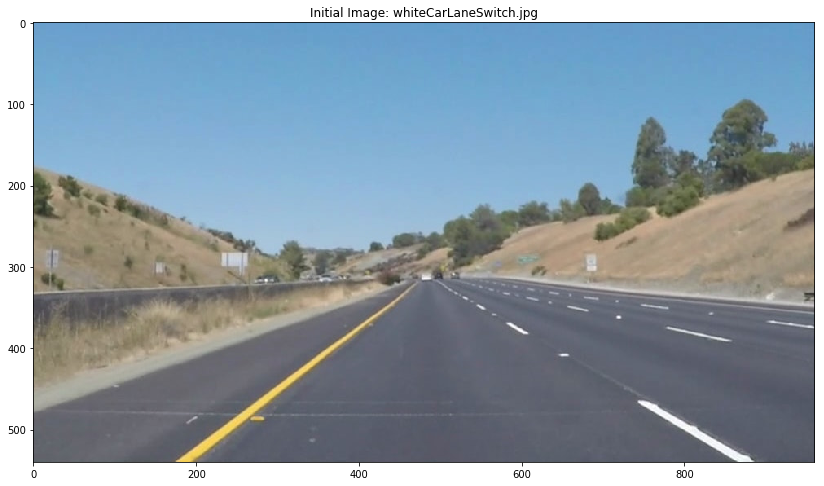

[238, 374, 179, 297, 372, 350, 228, 194]
[744, 756, 815, 585, 583, 821]


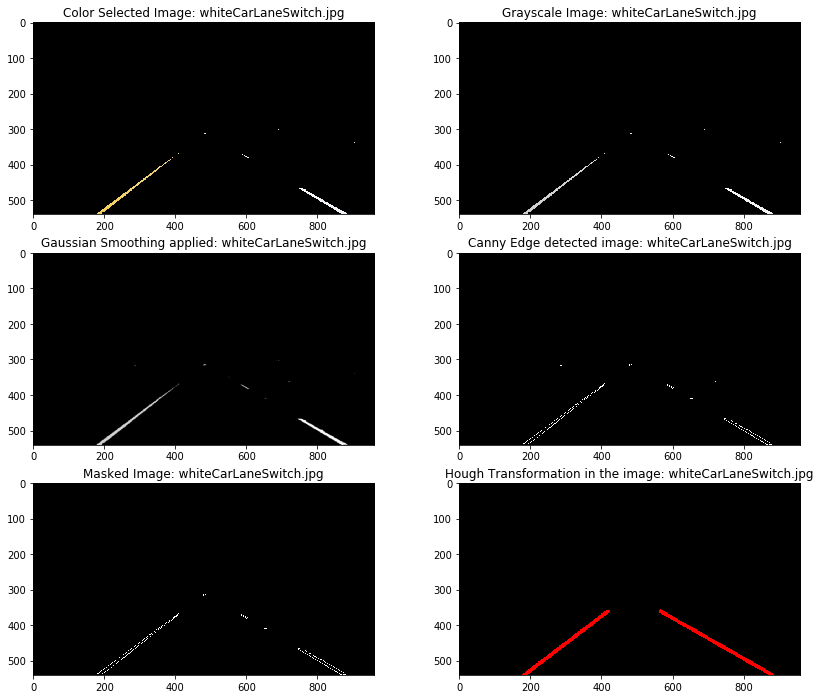

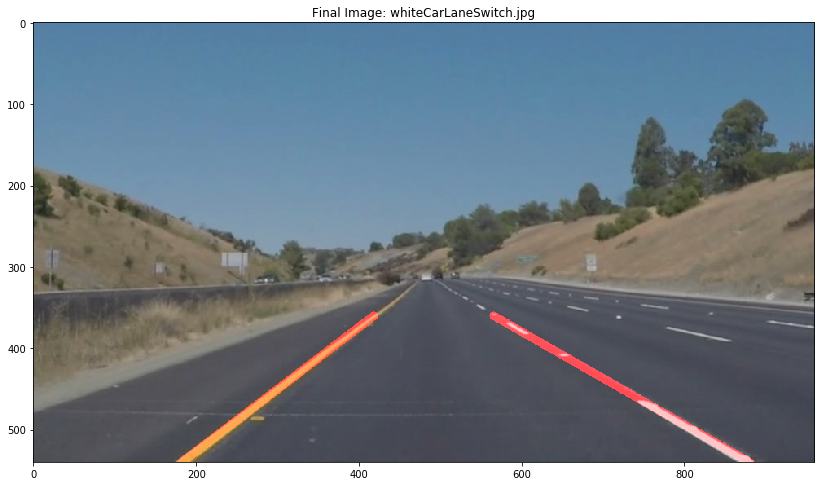

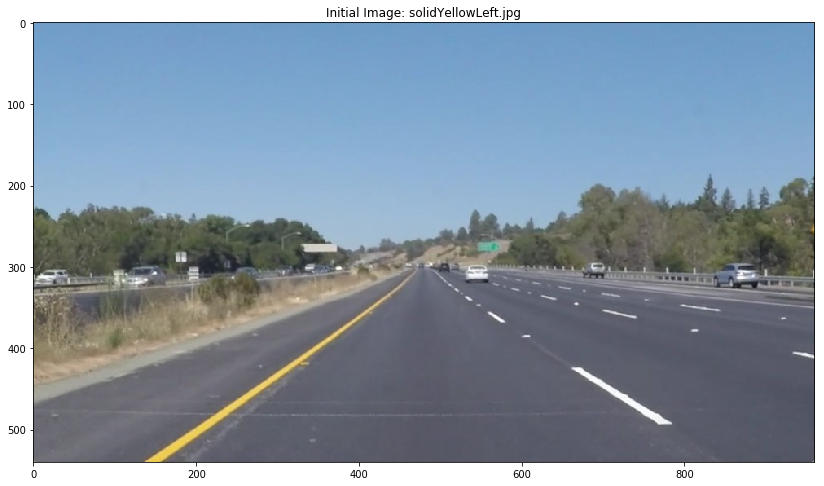

[245, 222, 148, 317, 163, 336, 201, 294]
[672, 717, 738, 692, 665]


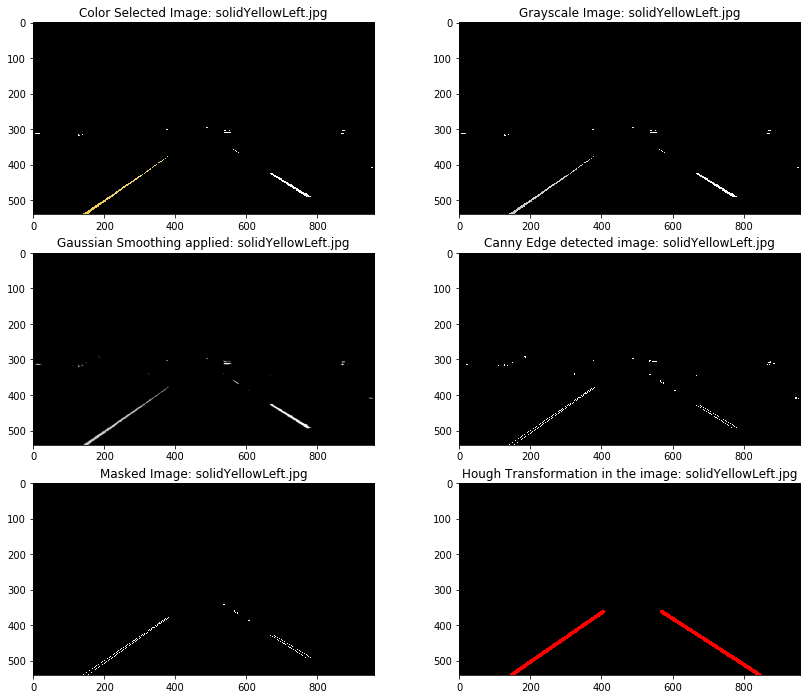

In [ ]:
image_names = os.listdir('test_images/')
#Listing out all the images in the test_images directory
print(image_names)
for image_name in image_names:
    if image_name.endswith('.jpg'):
        display_lanes_pipeline(image_name)
        print("")


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = finding_lanes_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:18<00:00, 12.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.28 s, sys: 264 ms, total: 7.55 s
Wall time: 19.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,6)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))